In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
import pickle as pkl
import os
from imblearn.over_sampling import SMOTE 


## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Add additional as required
os.chdir('/Users/priya/Documents/assignment1/assignment_1')
#os.chdir(Path.cwd().parent)
# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns



In [2]:
os.chdir('notebooks')

In [3]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

In [4]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [5]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')

In [6]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [7]:
print(df_train)

X_test

      Id_old     Id  GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA  ...  FTA  \
0      10556   3799  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  ...  2.9   
1       5342   3800  75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  ...  3.6   
2       5716   3801  85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  ...  0.6   
3      13790   3802  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  ...  1.5   
4       5470   3803  63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  ...  0.5   
...      ...    ...  ..   ...   ...  ...  ...   ...      ...  ...  ...  ...   
7995    2996  11794  32   9.2   1.8  0.7  1.8  40.3     -0.1 -0.2  ...  0.6   
7996   11679  11795  54   6.0   1.8  0.7  1.4  48.7      0.1  0.1  ...  0.4   
7997    5537  11796  85  28.2  10.7  4.0  9.0  45.1      0.2  0.6  ...  3.9   
7998    1292  11797  39   7.7   2.5  1.0  2.3  40.1     -0.3 -0.5  ...  0.7   
7999    2900  11798  49  19.2   4.8  1.7  5.1  32.6      0.7  2.4  ...  1.3   

       FT%  OREB  DREB  REB  AST  STL  BLK  TOV  TA

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,1,0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,...,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,8194,1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,...,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,3,2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,...,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,8196,3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,...,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,8197,4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,...,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,8175,3794,84,21.2,8.7,3.4,6.7,50.2,0.0,0.0,...,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,8176,3795,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,...,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,8178,3796,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,...,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,8181,3797,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,...,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [8]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

In [9]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)

In [10]:
X_test

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,84,21.2,8.7,3.4,6.7,50.2,0.0,0.0,-4.5,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [11]:
df_train.isnull().sum()

duplicate = df_train.duplicated()
print(duplicate.sum())

0


In [12]:
from imblearn.over_sampling import SMOTE 

In [13]:
scaler = StandardScaler()
df_cleaned = scaler.fit_transform(X)

In [14]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (8000, 19)
Shape of X after SMOTE: (13338, 19)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=8)

In [16]:
X_test

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,56,9.1,4.0,1.6,3.7,43.7,0.1,0.3,7.3,0.7,1.2,63.4,1.2,0.8,1.7,0.4,0.2,0.3,0.8
1,43,19.3,10.1,3.7,8.1,46.0,0.6,1.7,35.1,1.8,2.5,75.3,0.5,0.9,1.5,3.5,0.6,0.0,1.8
2,82,33.9,11.3,4.9,10.6,45.6,0.5,1.9,44.8,1.8,2.7,71.2,1.3,3.3,4.5,2.5,1.3,0.3,2.0
3,86,44.7,18.8,6.8,15.9,42.9,0.5,1.8,13.5,4.5,6.3,70.9,1.5,3.2,5.0,4.1,0.9,0.1,3.6
4,58,12.3,4.7,1.6,4.0,40.0,0.5,1.7,38.7,1.1,1.3,76.9,0.2,0.6,0.9,1.5,0.5,-0.4,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,84,21.2,8.7,3.4,6.7,50.2,0.0,0.0,-4.5,1.7,2.5,68.1,1.9,2.3,3.9,1.5,0.6,0.3,2.0
3795,49,16.3,6.4,2.9,6.6,44.4,-0.1,-0.4,19.8,1.0,1.9,50.2,1.7,2.8,4.4,0.4,0.4,0.4,0.7
3796,53,9.9,2.1,0.8,1.8,43.1,-0.4,-0.6,1.9,0.6,1.0,63.9,0.7,1.0,1.7,0.4,0.4,0.2,0.5
3797,89,38.3,14.5,5.4,11.8,45.2,0.5,1.2,24.7,2.5,2.9,89.2,1.5,4.0,5.5,3.7,1.3,0.3,2.4


In [17]:
X_test = scaler.fit_transform(X_test)

In [18]:
from sklearn import svm

clf = svm.SVC(kernel='linear', probability = True) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)

In [19]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.6574212893553223


In [20]:
print("Precision:",metrics.precision_score(y_val, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_val, y_pred))

Precision: 0.6786283891547049
Recall: 0.6248164464023495


In [21]:
clf.score(X_val, y_val)
clf.predict_proba(X_val)

array([[0.42648572, 0.57351428],
       [0.49134822, 0.50865178],
       [0.15618827, 0.84381173],
       ...,
       [0.70994438, 0.29005562],
       [0.52749014, 0.47250986],
       [0.61049175, 0.38950825]])

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val, y_pred)
print(confusion_matrix)

[[903 403]
 [511 851]]


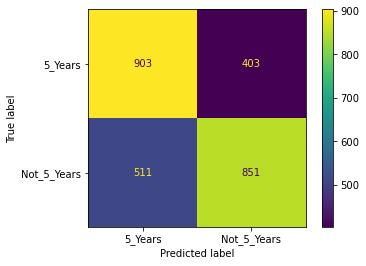

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['5_Years','Not_5_Years'])
cmd.plot()

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1306
           1       0.68      0.62      0.65      1362

    accuracy                           0.66      2668
   macro avg       0.66      0.66      0.66      2668
weighted avg       0.66      0.66      0.66      2668



In [25]:
roc=roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
roc

0.7343827651885684

In [26]:
final = clf.predict_proba(X_test)[:,1]

In [27]:
final

array([0.00669938, 0.02013386, 0.01934362, ..., 0.00060973, 0.03324594,
       0.00287801])

In [28]:
submit_predictions.submit_predictions(clf, X_test, test_id,"SVM_SMOTE model experiment", pred_path=processed_data_dir/'13684182_week2_SVM_SMOTE_Final.csv')

Success! User is Authenticated


100%|██████████| 95.0k/95.0k [00:06<00:00, 14.2kB/s]


,id,TARGET_5Yrs
0,0,0.006699
1,1,0.020134
2,2,0.019344
3,3,0.033333
4,4,0.006383
...,...,...
3794,3794,0.009651
3795,3795,0.006992
3796,3796,0.000610
3797,3797,0.033246


In [29]:
file_name = models_dir /'priyanka_srinivasa_13684182_week2_SVM_SMOTE_Final.sav'
pkl.dump(clf, open(file_name, 'wb'))